In [15]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(rc={'figure.figsize':(10,6)})

In [16]:
losses = torch.load('models/unpruned_model_huber_losses.pt')
print(losses)

[1086143.1333333333, 1012880.84, 948899.8133333334, 900706.8733333333, 874450.8066666666, 864303.0666666667, 862769.0433333333, 863674.1333333333, 864245.5733333334, 864768.6533333333, 865028.92, 865079.33, 865023.0233333333, 864596.9666666667, 863971.2033333334, 863245.4533333334, 862438.32, 861562.5466666666, 860628.32, 859645.3466666667, 858622.02, 857556.86, 856423.0933333334, 855080.515, 853724.125, 852406.8133333334, 851116.4466666667, 849823.5883333334, 848626.0216666666, 847440.7833333333, 846282.975, 845228.4216666666, 843123.01, 839950.34, 837158.7116666667, 835744.7566666667, 835832.27, 835764.4033333333, 833995.5233333333, 832562.695, 832414.3666666667, 832283.01, 832233.7133333334, 831948.86, 831353.5016666667, 830729.1633333333, 830174.2083333334, 829859.2716666666, 829433.1783333333, 827602.9933333333, 821503.2383333333, 822424.4533333334, 816591.825, 818833.9666666667, 819450.5766666667, 818357.5783333334, 818669.32, 816167.9, 816053.3833333333, 817015.38, 816671.99, 81

Text(0, 0.5, 'Loss (MAE)')

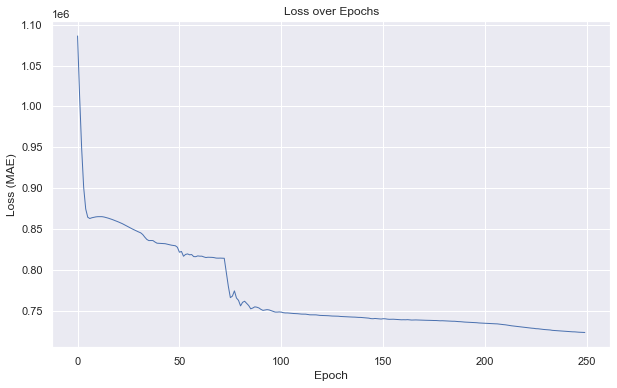

In [17]:
ax = sns.lineplot(losses, linewidth=1)
ax.set_title('Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (MAE)')


# Model Performance Visualizations

In [18]:
# Setup Model
from model import GCN

model = GCN()
model.load_state_dict(torch.load("models/unpruned_model_huber.pt"))
model = model.eval()

In [19]:
data = torch.load("datasets/unpruned/SG256_SM_Only_Train.pt")

y_truth = np.array([])
y_pred = np.array([])
for graph in data:
    graph.x = torch.tensor([[data[0], data[1]] for data in graph.x])
    
    for item in graph.y:
        y_truth = np.append(y_truth, item)

    out = model(graph)
    for item in out.tolist():
        y_pred = np.append(y_pred, item[0])

print(len(y_pred), len(y_truth))
print(y_pred, y_truth)


27101 27101
[7719.49755859 -299.22390747 6849.95849609 ...  437.7046814   113.52180481
    9.19952774] [3676.68066406 3676.68066406 3676.68066406 ... 1779.7598877  1779.7598877
 1779.7598877 ]


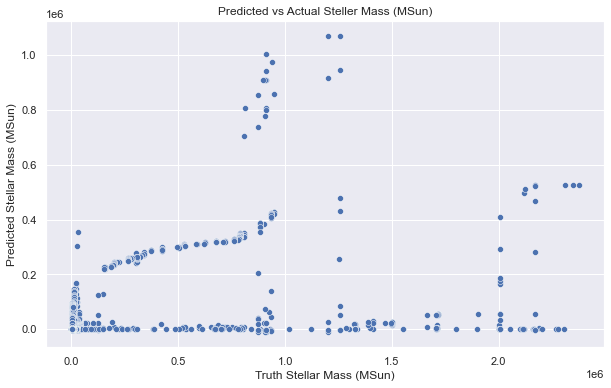

In [20]:
ax = sns.scatterplot(x=y_truth, y=y_pred)
ax.set_title('Predicted vs Actual Steller Mass (MSun)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
ax.set_ylabel('Predicted Stellar Mass (MSun)')
ax.autoscale(True)

Mean absolute error: 189.81006560476834%


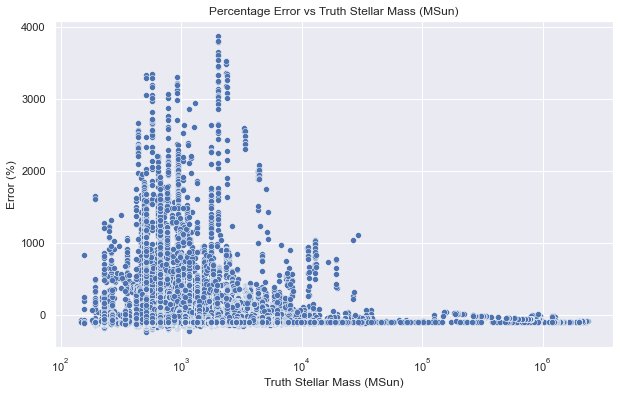

In [21]:
error = ((y_pred - y_truth) / y_truth) * 100
ax = sns.scatterplot(x=y_truth, y=error)
ax.set_xscale('log')
ax.set_title('Percentage Error vs Truth Stellar Mass (MSun)')
ax.set_ylabel('Error (%)')
ax.set_xlabel('Truth Stellar Mass (MSun)')
print(f'Mean absolute error: {np.mean(np.abs(error))}%')